No model was supplied, defaulted to distilbert/distilbert-base-cased-distilled-squad and revision 564e9b5 (https://huggingface.co/distilbert/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0


Step 1 - Default Model QA:
{'score': 0.998332679271698, 'start': 1, 'end': 16, 'answer': 'Charles Babbage'}



Device set to use cuda:0


Step 2 - Custom Model QA (roberta-base-squad2):
{'score': 0.9770565629005432, 'start': 1, 'end': 16, 'answer': 'Charles Babbage'}

Step 3 - Custom Questions on Own Context:
Q: Where is the Eiffel Tower located?
A: {'score': 0.9596447944641113, 'start': 32, 'end': 45, 'answer': 'Paris, France'}
Q: How tall is the Eiffel Tower?
A: {'score': 0.4633811414241791, 'start': 164, 'end': 174, 'answer': '300 meters'}
Training Conditional GAN...
Epoch [1/5] | Loss D: 0.2209 | Loss G: 2.1130
Epoch [2/5] | Loss D: 0.9231 | Loss G: 1.3178
Epoch [3/5] | Loss D: 0.4014 | Loss G: 1.9213
Epoch [4/5] | Loss D: 0.7154 | Loss G: 1.4625
Epoch [5/5] | Loss D: 0.7032 | Loss G: 1.4630


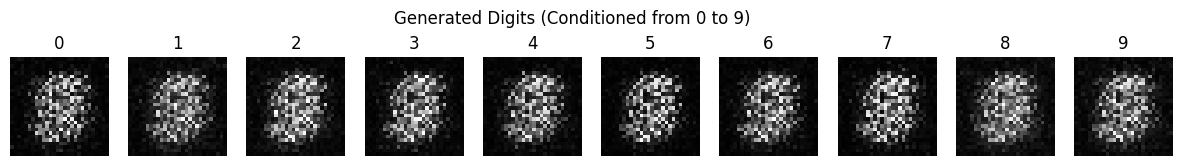

In [4]:
from transformers import pipeline

# 1. Basic Pipeline Setup
qa_pipeline = pipeline("question-answering")

context_1 = """
Charles Babbage was an English mathematician and inventor. He is credited with inventing the first mechanical computer,

"""

question_1 = "Who is credited with inventing the first mechanical computer?"

result_1 = qa_pipeline(question=question_1, context=context_1)
print("Step 1 - Default Model QA:")
print(result_1)
print()

# 2. Use a Custom Pretrained Model
qa_pipeline_custom = pipeline("question-answering", model="deepset/roberta-base-squad2")

result_2 = qa_pipeline_custom(question=question_1, context=context_1)
print("Step 2 - Custom Model QA (roberta-base-squad2):")
print(result_2)
 # Expected 'answer': 'Charles Babbage', score > 0.70
print()

# 3. Test on Your Own Example
context_2 = """
The Eiffel Tower is located in Paris, France. It was constructed in 1889 and remains one of the most visited landmarks in the world.
The structure stands at about 300 meters tall and was originally built as the entrance to the 1889 World's Fair.
"""

question_3a = "Where is the Eiffel Tower located?"
question_3b = "How tall is the Eiffel Tower?"

result_3a = qa_pipeline_custom(question=question_3a, context=context_2)
result_3b = qa_pipeline_custom(question=question_3b, context=context_2)

print("Step 3 - Custom Questions on Own Context:")
print(f"Q: {question_3a}\nA: {result_3a}")
print(f"Q: {question_3b}\nA: {result_3b}")


#2 Question
# Conditional GAN: Generate MNIST digits based on labels (0–9)

# ------------------------------
# 1. Install & Import Libraries
# ------------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------
# 2. Hyperparameters & Device
# ------------------------------
latent_dim = 100
embedding_dim = 10
batch_size = 128
epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------
# 3. Load MNIST Dataset
# ------------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
mnist = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
loader = DataLoader(mnist, batch_size=batch_size, shuffle=True)

# ------------------------------
# 4. Define Generator
# ------------------------------
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_embed = nn.Embedding(10, embedding_dim)
        self.model = nn.Sequential(
            nn.Linear(latent_dim + embedding_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 784),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_input = self.label_embed(labels)
        x = torch.cat([noise, label_input], dim=1)
        img = self.model(x)
        return img.view(-1, 1, 28, 28)

# ------------------------------
# 5. Define Discriminator
# ------------------------------
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_embed = nn.Embedding(10, embedding_dim)
        self.model = nn.Sequential(
            nn.Linear(784 + embedding_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_input = self.label_embed(labels)
        x = torch.cat([img.view(img.size(0), -1), label_input], dim=1)
        return self.model(x)

# ------------------------------
# 6. Initialize Models and Optimizers
# ------------------------------
G = Generator().to(device)
D = Discriminator().to(device)

loss_fn = nn.BCELoss()
opt_G = optim.Adam(G.parameters(), lr=0.0002)
opt_D = optim.Adam(D.parameters(), lr=0.0002)

# ------------------------------
# 7. Train the cGAN
# ------------------------------
print("Training Conditional GAN...")

for epoch in range(epochs):
    for real_imgs, labels in loader:
        real_imgs, labels = real_imgs.to(device), labels.to(device)
        batch_size = real_imgs.size(0)

        # Real and fake labels
        real = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        # ---- Train Discriminator ----
        noise = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = G(noise, labels)
        real_loss = loss_fn(D(real_imgs, labels), real)
        fake_loss = loss_fn(D(fake_imgs.detach(), labels), fake)
        loss_D = real_loss + fake_loss

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # ---- Train Generator ----
        noise = torch.randn(batch_size, latent_dim).to(device)
        gen_imgs = G(noise, labels)
        loss_G = loss_fn(D(gen_imgs, labels), real)

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

    print(f"Epoch [{epoch+1}/{epochs}] | Loss D: {loss_D.item():.4f} | Loss G: {loss_G.item():.4f}")

# ------------------------------
# 8. Visualize Digits Label by Label (0–9)
# ------------------------------
def generate_by_label():
    G.eval()
    noise = torch.randn(10, latent_dim).to(device)
    labels = torch.arange(0, 10).to(device)
    gen_imgs = G(noise, labels).detach().cpu()

    fig, axes = plt.subplots(1, 10, figsize=(15, 2))
    for i in range(10):
        axes[i].imshow(gen_imgs[i].squeeze(), cmap="gray")
        axes[i].axis("off")
        axes[i].set_title(str(i))
    plt.suptitle("Generated Digits (Conditioned from 0 to 9)")
    plt.show()

generate_by_label()
